In [44]:
from qiskit.transpiler.coupling import CouplingMap
import numpy as np

# Import from Qiskit Aer noise module

from mirror_gates.noisy_fidelity import get_noisy_fidelity
from tqdm import tqdm

from qiskit.circuit.random import random_circuit
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import QFT
from qiskit.transpiler import CouplingMap
from mirror_gates.noisy_fidelity import T1, T2

In [45]:
N = 8
# coupling_map = CouplingMap.from_full(N)
coupling_map = CouplingMap.from_line(N)

data1 = []

for i in tqdm(range(2, 100, 4)):
    qc = random_circuit(N, i, max_operands=2, measure=False)
    fid, duration, transp = get_noisy_fidelity(qc, coupling_map)
    data1.append((i, duration, fid))  # Added depth (i) here

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


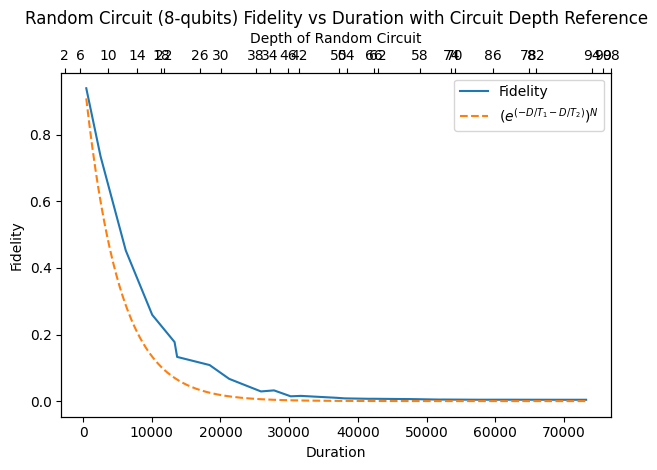

In [46]:
# sort by duration
data1 = sorted(data1, key=lambda x: x[1])
depths_sorted, durations_sorted, fidelities_sorted = zip(*data1)

fig, ax1 = plt.subplots()

# Plotting the fidelity vs. duration (main line)
ax1.set_xlabel("Duration")
ax1.set_ylabel("Fidelity")
ax1.plot(durations_sorted, fidelities_sorted, label="Fidelity")

# Setting the secondary x-axis for the depth of the random circuit
ax2 = ax1.twiny()
ax2.set_xlabel("Depth of Random Circuit")
ax2.set_xticks(durations_sorted)
ax2.set_xticklabels(depths_sorted)

# Smooth reference line
T1, T2 = 80e3, 80e3

n_qubits = N
duration_samples = np.linspace(min(durations_sorted), max(durations_sorted), 500)
decay_factor = [(1 / T1 + 1 / T2) * duration for duration in duration_samples]
single_qubit_fidelity = [np.exp(-factor) for factor in decay_factor]
total_fidelity = [fidelity**n_qubits for fidelity in single_qubit_fidelity]
label_string = r"$\left( e^{(-D/T_1 -D/T_2)} \right)^{N}$"

ax1.plot(duration_samples, total_fidelity, label=label_string, linestyle="--")
ax1.legend()


plt.title("Random Circuit (8-qubits) Fidelity vs Duration with Circuit Depth Reference")
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [47]:
N = 8
coupling_map = CouplingMap.from_full(N)
data2 = []

for i in tqdm(range(2, N + 1)):
    qc = QFT(i)
    fid, duration, transp = get_noisy_fidelity(qc, coupling_map)
    data2.append((i, duration, fid))

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


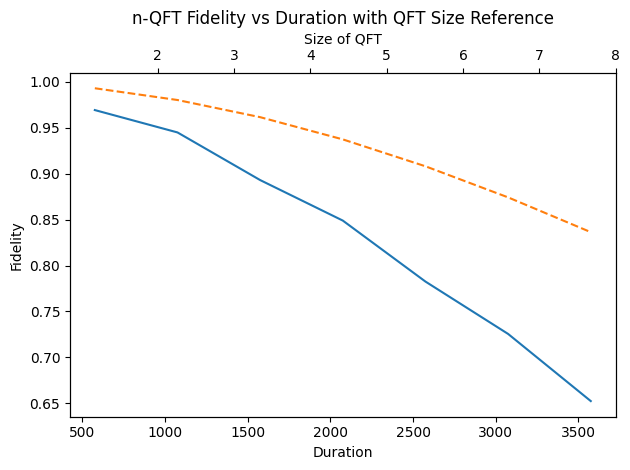

In [49]:
# sort by duration
data2 = sorted(data2, key=lambda x: x[1])
sizes_sorted, durations_sorted, fidelities_sorted = zip(*data2)
fig, ax1 = plt.subplots()

# Plotting the fidelity vs. duration (main line)
ax1.set_xlabel("Duration")
ax1.set_ylabel("Fidelity")
ax1.plot(durations_sorted, fidelities_sorted, label="Fidelity")
ax1.tick_params(axis="y")

# Setting the secondary x-axis for the size of QFT
ax2 = ax1.twiny()
ax2.set_xlabel("Size of QFT")
ax2.set_xticks(durations_sorted)
ax2.set_xticklabels(sizes_sorted)
ax2.tick_params(axis="x")

# Adjusting the reference line calculation
unique_sizes = list(set(sizes_sorted))
reference_y_total = []
duration_samples_total = []

for size in unique_sizes:
    min_duration = min(
        [
            duration
            for size_curr, duration in zip(sizes_sorted, durations_sorted)
            if size_curr == size
        ]
    )
    max_duration = max(
        [
            duration
            for size_curr, duration in zip(sizes_sorted, durations_sorted)
            if size_curr == size
        ]
    )
    duration_samples = np.linspace(min_duration, max_duration, 100)
    reference_y = [
        np.exp(-size * duration / (T1 + T2)) for duration in duration_samples
    ]

    reference_y_total.extend(reference_y)
    duration_samples_total.extend(duration_samples)

ax1.plot(
    duration_samples_total,
    reference_y_total,
    label="e^{-nD / (T_1+T_2)}",
    linestyle="--",
)


plt.title("n-QFT Fidelity vs Duration with QFT Size Reference")
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()